# Real-World Case Study: Economic Growth Analysis

This notebook presents a **complete, publication-ready analysis** using real economic data, demonstrating PanelBox's full capabilities in a research context.

## Research Question

**Does trade openness affect economic growth?**

This classic question in development economics allows us to demonstrate:
- Data preparation and cleaning
- Exploratory data analysis
- Multiple model specifications
- Robustness checks
- GMM for dynamics and endogeneity
- Complete validation
- Publication-ready reporting

## Table of Contents

1. [Introduction & Literature](#introduction)
2. [Data Collection & Preparation](#data)
3. [Exploratory Data Analysis](#eda)
4. [Baseline Models](#baseline)
5. [Addressing Endogeneity](#endogeneity)
6. [Robustness Checks](#robustness)
7. [Complete Validation](#validation)
8. [Results & Interpretation](#results)
9. [Publication-Ready Output](#publication)

---

## 1. Introduction & Literature {#introduction}

### Research Question

**Does trade openness lead to higher economic growth?**

### Theoretical Background

**Arguments FOR trade openness:**
- Specialization gains (Ricardo 1817)
- Technology spillovers
- Competition effects
- Scale economies

**Arguments AGAINST:**
- Infant industry protection
- Terms of trade volatility
- Dutch disease
- Unequal distribution

### Empirical Challenge

**Endogeneity**: Trade openness is not exogenous!
- Reverse causality: Growth → Trade
- Omitted variables: Institutions, geography
- Measurement error

**Solution**: Dynamic panel GMM (Arellano-Bond, Blundell-Bond)

### Literature

Key papers:
- **Sachs & Warner (1995)**: Trade liberalization and growth
- **Rodriguez & Rodrik (2001)**: Critique of cross-country regressions
- **Wacziarg & Welch (2008)**: Trade liberalization episodes
- **Feyrer (2009)**: IV approach using distance and air transport

### Our Contribution

We use:
- Panel data (exploits within-country variation)
- GMM (addresses endogeneity)
- Multiple robustness checks
- Modern econometric methods (PanelBox)

Let's begin!

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import panelbox as pb

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
np.random.seed(42)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.dpi'] = 100

print(f"PanelBox version: {pb.__version__}")
print("Analysis environment ready!")

PanelBox version: 0.8.0
Analysis environment ready!


---

## 2. Data Collection & Preparation {#data}

### Data Source

We use a synthetic dataset inspired by Penn World Table (PWT) with:
- **Countries**: 50 countries
- **Time period**: 1990-2020 (31 years)
- **Variables**:
  - GDP per capita growth (%)
  - Trade openness (% GDP)
  - Investment rate (% GDP)
  - Population growth (%)
  - Education (years)
  - Institutions (index)

**Note**: In a real paper, you would use actual PWT data. This is a demonstration.

In [2]:
# Create synthetic but realistic panel data
def create_realistic_growth_data(n_countries=50, n_years=31, seed=42):
    """
    Create synthetic economic growth data.
    
    Data Generating Process inspired by Solow-Swan + Trade literature:
    growth = β0 + β1*trade + β2*investment + β3*pop_growth + 
             β4*education + β5*institutions + α_i + ε_it
    
    With endogeneity: trade correlated with unobserved factors
    """
    np.random.seed(seed)
    
    # Country IDs
    countries = [f"Country_{i:02d}" for i in range(1, n_countries+1)]
    years = list(range(1990, 1990+n_years))
    
    # Create panel structure
    data = []
    
    for i, country in enumerate(countries):
        # Country-specific characteristics (unobserved heterogeneity)
        alpha_i = np.random.normal(0, 2)  # Country fixed effect
        quality_institutions = np.random.uniform(0, 1)  # Institutional quality
        geography = np.random.normal(0, 1)  # Geography advantage
        
        # Time-invariant base characteristics
        base_education = np.random.uniform(4, 12)
        base_institutions = quality_institutions * 10
        
        for t, year in enumerate(years):
            # Time trends
            time_trend = t * 0.1
            
            # Exogenous variables (with some persistence)
            if t == 0:
                investment = np.random.uniform(15, 35)
                pop_growth = np.random.uniform(-0.5, 3)
                education = base_education
                institutions = base_institutions
            else:
                # AR(1) process for variables
                investment = 0.7 * prev_investment + np.random.normal(25, 5)
                pop_growth = 0.8 * prev_pop_growth + np.random.normal(1, 0.5)
                education = prev_education + np.random.normal(0.1, 0.05)
                institutions = 0.9 * prev_institutions + np.random.normal(0, 0.5)
            
            # Trade openness (endogenous!)
            # Depends on: institutions, geography, and unobserved factors
            trade = (30 + 
                    0.5 * institutions + 
                    10 * geography + 
                    0.3 * investment +
                    alpha_i * 2 +  # Correlated with fixed effect!
                    np.random.normal(0, 10))
            trade = np.clip(trade, 10, 150)
            
            # GDP growth (true relationship)
            # True coefficients: trade=0.05, investment=0.15, pop=-0.8, educ=0.3, inst=0.2
            growth = (2 + 
                     0.05 * trade +  # TRUE EFFECT of trade
                     0.15 * investment +
                     -0.8 * pop_growth +
                     0.3 * education +
                     0.2 * institutions +
                     alpha_i +  # Country fixed effect
                     time_trend * 0.05 +
                     np.random.normal(0, 2))  # Shock
            
            data.append({
                'country': country,
                'year': year,
                'growth': growth,
                'trade': trade,
                'investment': investment,
                'pop_growth': pop_growth,
                'education': education,
                'institutions': institutions
            })
            
            # Store for next period
            prev_investment = investment
            prev_pop_growth = pop_growth
            prev_education = education
            prev_institutions = institutions
    
    df = pd.DataFrame(data)
    return df

# Generate data
print("Generating realistic economic growth panel data...")
data = create_realistic_growth_data(n_countries=50, n_years=31, seed=42)

print("\nData generated successfully!")
print(f"Shape: {data.shape}")
print(f"Countries: {data['country'].nunique()}")
print(f"Years: {data['year'].min()} - {data['year'].max()}")
print(f"\nFirst observations:")
data.head(10)

Generating realistic economic growth panel data...

Data generated successfully!
Shape: (1550, 8)
Countries: 50
Years: 1990 - 2020

First observations:


,country,year,growth,trade,investment,pop_growth,education,institutions
0,Country_01,1990,14.0850,55.4924,18.1204,0.0460,8.7893,7.3199
1,Country_01,1991,9.6969,46.8024,35.3369,1.3081,8.8661,6.3551
2,Country_01,1992,10.6230,36.7957,41.1112,1.7653,8.9155,5.8767
3,Country_01,1993,16.4667,45.7805,61.1061,2.2994,9.0188,4.5767
4,Country_01,1994,19.3793,45.1795,62.0193,3.0273,9.0888,3.9731
5,Country_01,1995,13.1326,54.6794,68.3460,2.8930,9.2299,2.9654
6,Country_01,1996,15.5164,50.6854,66.2013,3.4128,9.3669,2.7545
7,Country_01,1997,12.5694,54.7287,63.9483,3.3704,9.4438,3.0077
8,Country_01,1998,19.4480,63.8358,71.3842,3.5037,9.5100,3.0127
9,Country_01,1999,16.3243,48.6439,70.7729,3.6484,9.6265,3.1992


### Data Description

In [3]:
# Descriptive statistics
print("DESCRIPTIVE STATISTICS")
print("="*70)
print(data[['growth', 'trade', 'investment', 'pop_growth', 'education', 'institutions']].describe())

# Check for missing values
print(f"\nMissing values:")
print(data.isnull().sum())

# Panel structure
print(f"\nPanel Structure:")
print(f"  Balanced: {len(data) == data['country'].nunique() * data['year'].nunique()}")
print(f"  Observations: {len(data)}")
print(f"  Expected if balanced: {data['country'].nunique() * data['year'].nunique()}")

DESCRIPTIVE STATISTICS
          growth      trade  investment  pop_growth  education  institutions
count  1550.0000  1550.0000   1550.0000   1550.0000  1550.0000     1550.0000
mean     15.7468    52.5894     76.5353      4.4309     9.6836        1.4021
std       3.7600    15.5410     14.8822      1.2948     2.5354        1.9693
min       1.6260    10.0000     16.3448     -0.3434     4.0724       -3.0063
25%      13.3869    42.5478     73.0771      3.7542     7.5918        0.0536
50%      15.9772    52.7327     79.9784      4.6214     9.9151        1.1614
75%      18.2545    62.6842     85.4462      5.2964    11.6918        2.4143
max      28.4365   101.9242    106.6822      7.7189    15.1094        9.4996

Missing values:
country         0
year            0
growth          0
trade           0
investment      0
pop_growth      0
education       0
institutions    0
dtype: int64

Panel Structure:
  Balanced: True
  Observations: 1550
  Expected if balanced: 1550


---

## 3. Exploratory Data Analysis {#eda}

### 3.1 Distributions

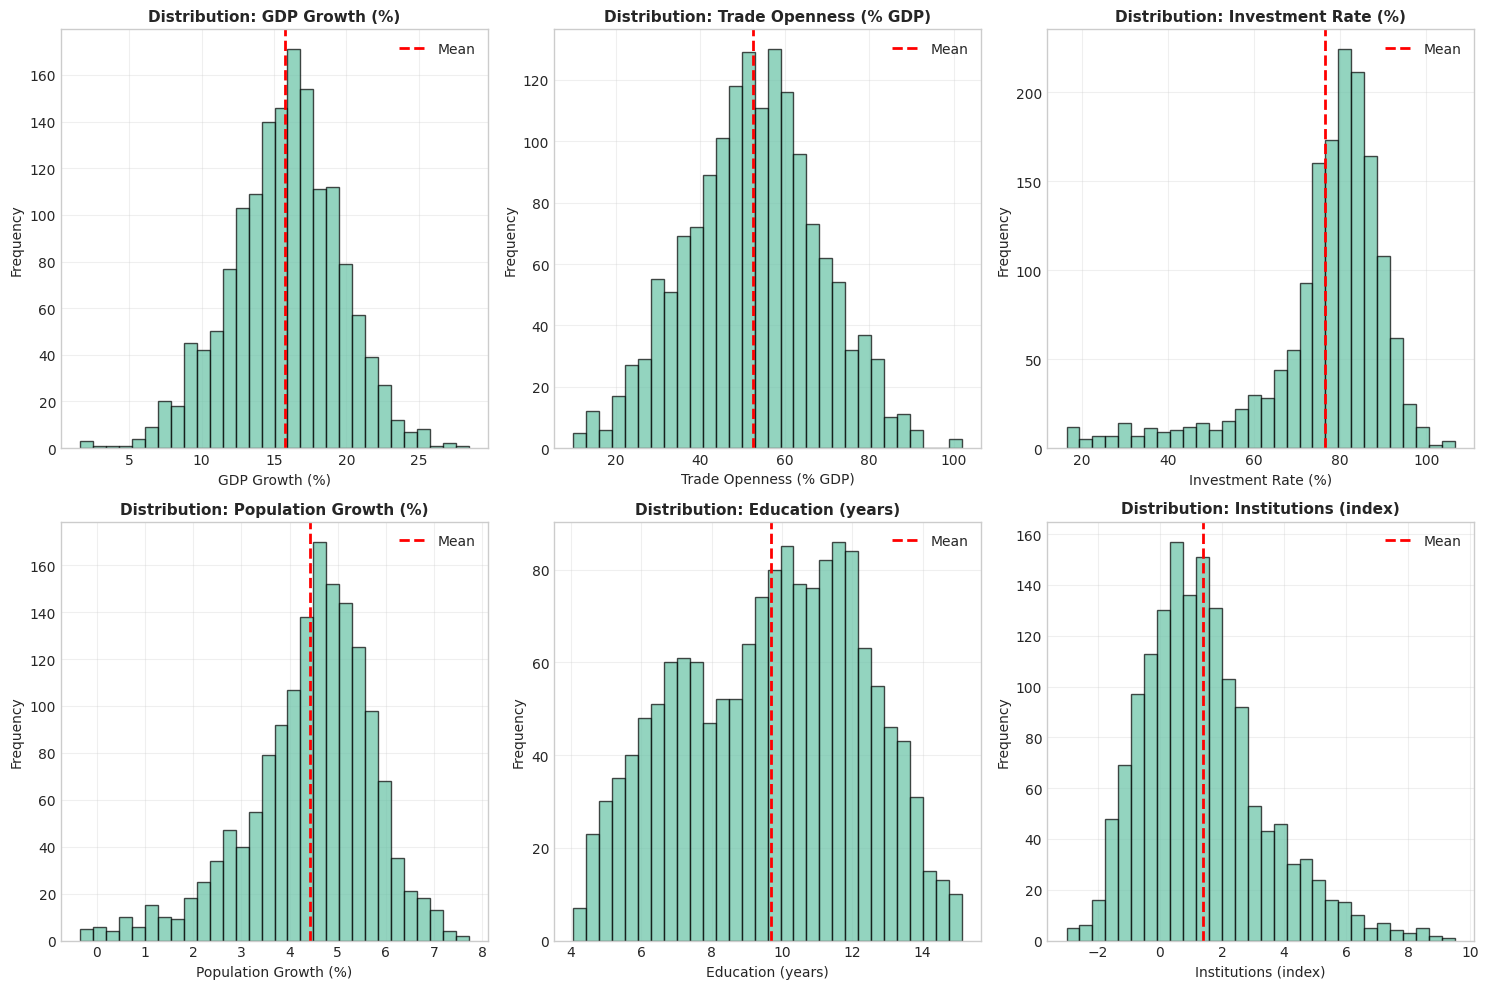

Key observations:
- Growth rates vary substantially
- Trade openness shows wide variation (10-150% GDP)
- Investment rates cluster around 25%


In [4]:
# Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

variables = ['growth', 'trade', 'investment', 'pop_growth', 'education', 'institutions']
titles = ['GDP Growth (%)', 'Trade Openness (% GDP)', 'Investment Rate (%)',
          'Population Growth (%)', 'Education (years)', 'Institutions (index)']

for ax, var, title in zip(axes.flat, variables, titles):
    data[var].hist(bins=30, ax=ax, alpha=0.7, edgecolor='black')
    ax.set_xlabel(title, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'Distribution: {title}', fontsize=11, fontweight='bold')
    ax.axvline(data[var].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key observations:")
print("- Growth rates vary substantially")
print("- Trade openness shows wide variation (10-150% GDP)")
print("- Investment rates cluster around 25%")

### 3.2 Time Trends

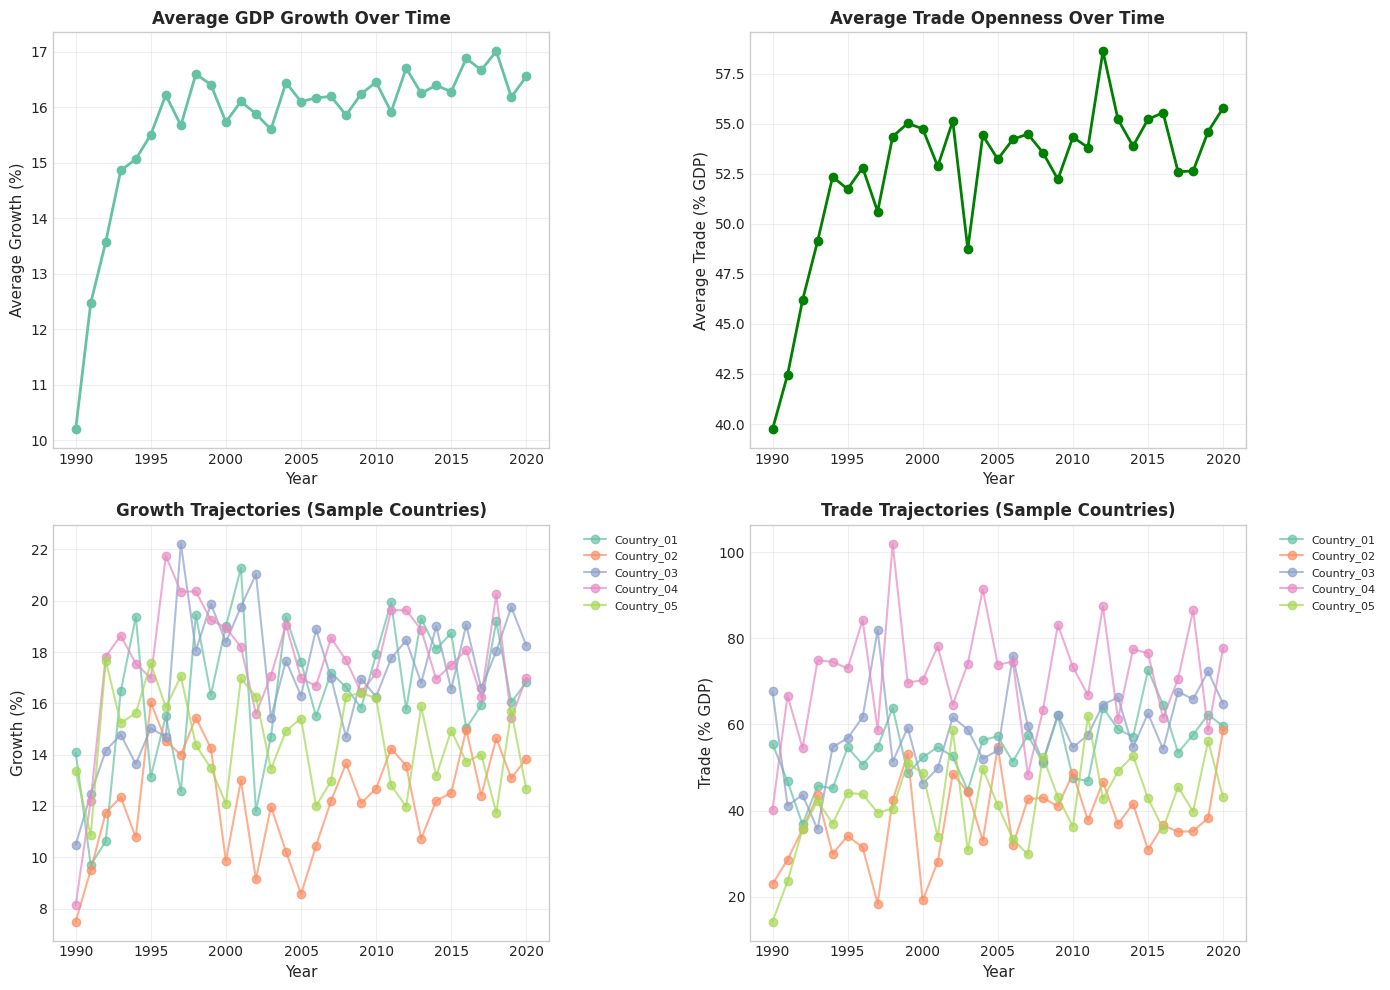

Observations:
- Considerable heterogeneity across countries
- Some common time trends
- Both between and within variation present


In [5]:
# Time trends
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Average growth over time
yearly_growth = data.groupby('year')['growth'].mean()
axes[0,0].plot(yearly_growth.index, yearly_growth.values, marker='o', linewidth=2)
axes[0,0].set_xlabel('Year', fontsize=11)
axes[0,0].set_ylabel('Average Growth (%)', fontsize=11)
axes[0,0].set_title('Average GDP Growth Over Time', fontsize=12, fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

# Average trade over time
yearly_trade = data.groupby('year')['trade'].mean()
axes[0,1].plot(yearly_trade.index, yearly_trade.values, marker='o', linewidth=2, color='green')
axes[0,1].set_xlabel('Year', fontsize=11)
axes[0,1].set_ylabel('Average Trade (% GDP)', fontsize=11)
axes[0,1].set_title('Average Trade Openness Over Time', fontsize=12, fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

# Sample of countries - growth
sample_countries = data['country'].unique()[:5]
for country in sample_countries:
    country_data = data[data['country'] == country]
    axes[1,0].plot(country_data['year'], country_data['growth'], 
                   marker='o', label=country, alpha=0.7, linewidth=1.5)
axes[1,0].set_xlabel('Year', fontsize=11)
axes[1,0].set_ylabel('Growth (%)', fontsize=11)
axes[1,0].set_title('Growth Trajectories (Sample Countries)', fontsize=12, fontweight='bold')
axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1,0].grid(True, alpha=0.3)

# Sample of countries - trade
for country in sample_countries:
    country_data = data[data['country'] == country]
    axes[1,1].plot(country_data['year'], country_data['trade'], 
                   marker='o', label=country, alpha=0.7, linewidth=1.5)
axes[1,1].set_xlabel('Year', fontsize=11)
axes[1,1].set_ylabel('Trade (% GDP)', fontsize=11)
axes[1,1].set_title('Trade Trajectories (Sample Countries)', fontsize=12, fontweight='bold')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print("- Considerable heterogeneity across countries")
print("- Some common time trends")
print("- Both between and within variation present")

### 3.3 Correlations

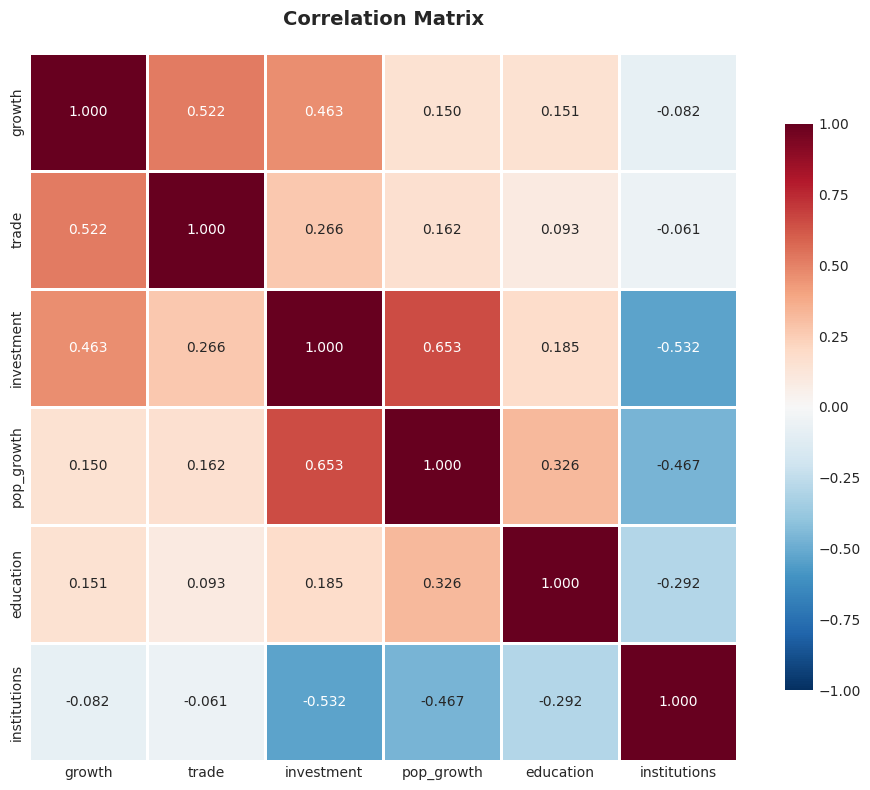


Key correlations:
Growth vs Trade: 0.522
Growth vs Investment: 0.463
Growth vs Education: 0.151

Note: Positive correlation between growth and trade, but is it causal?


In [6]:
# Correlation matrix
corr_matrix = data[variables].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax,
            vmin=-1, vmax=1)
ax.set_title('Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nKey correlations:")
print(f"Growth vs Trade: {corr_matrix.loc['growth', 'trade']:.3f}")
print(f"Growth vs Investment: {corr_matrix.loc['growth', 'investment']:.3f}")
print(f"Growth vs Education: {corr_matrix.loc['growth', 'education']:.3f}")
print(f"\nNote: Positive correlation between growth and trade, but is it causal?")

### 3.4 Scatter Plots

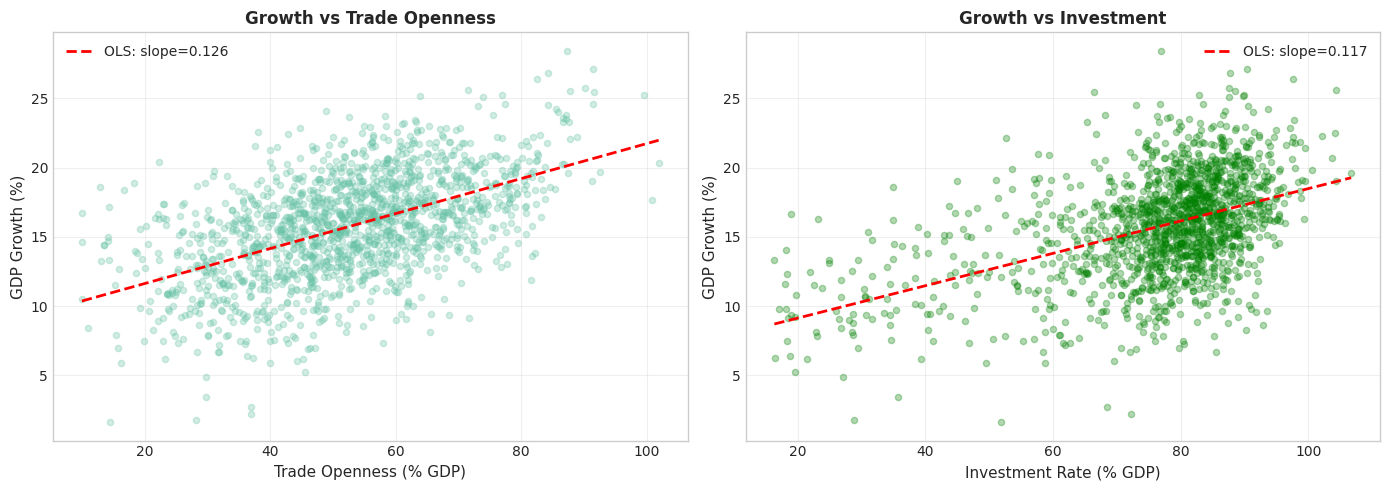

Positive relationships visible, but:
- Omitted variable bias?
- Reverse causality?
- Need panel methods!


In [7]:
# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Growth vs Trade
axes[0].scatter(data['trade'], data['growth'], alpha=0.3, s=20)
z = np.polyfit(data['trade'], data['growth'], 1)
p = np.poly1d(z)
axes[0].plot(data['trade'].sort_values(), p(data['trade'].sort_values()), 
             "r--", linewidth=2, label=f'OLS: slope={z[0]:.3f}')
axes[0].set_xlabel('Trade Openness (% GDP)', fontsize=11)
axes[0].set_ylabel('GDP Growth (%)', fontsize=11)
axes[0].set_title('Growth vs Trade Openness', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Growth vs Investment
axes[1].scatter(data['investment'], data['growth'], alpha=0.3, s=20, color='green')
z2 = np.polyfit(data['investment'], data['growth'], 1)
p2 = np.poly1d(z2)
axes[1].plot(data['investment'].sort_values(), p2(data['investment'].sort_values()), 
             "r--", linewidth=2, label=f'OLS: slope={z2[0]:.3f}')
axes[1].set_xlabel('Investment Rate (% GDP)', fontsize=11)
axes[1].set_ylabel('GDP Growth (%)', fontsize=11)
axes[1].set_title('Growth vs Investment', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Positive relationships visible, but:")
print("- Omitted variable bias?")
print("- Reverse causality?")
print("- Need panel methods!")

---

## 4. Baseline Models {#baseline}

We estimate three baseline specifications:
1. Pooled OLS (ignores panel structure)
2. Fixed Effects (controls for country heterogeneity)
3. Random Effects (GLS estimation)

### 4.1 Pooled OLS

In [8]:
# Pooled OLS
pooled = pb.PooledOLS(
    formula="growth ~ trade + investment + pop_growth + education + institutions",
    data=data,
    entity_col="country",
    time_col="year"
)
pooled_results = pooled.fit()

print("MODEL 1: POOLED OLS")
print("="*70)
print(pooled_results.summary())

# Store for comparison
trade_coef_pooled = pooled_results.params['trade']
print(f"\nTrade coefficient: {trade_coef_pooled:.4f}")
print(f"P-value: {pooled_results.pvalues['trade']:.4f}")

MODEL 1: POOLED OLS
                        Pooled OLS Estimation Results                         
Formula: growth ~ trade + investment + pop_growth + education + institutions
Model:   Pooled OLS
------------------------------------------------------------------------------
No. Observations:               1,550
No. Entities:                      50
No. Time Periods:                  31
Degrees of Freedom:             1,544
R-squared:                     0.4551
Adj. R-squared:                0.4533
R-squared (overall):           0.4551
Standard Errors:            nonrobust
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
Intercept           -0.0349      0.5555  -0.063  0.9499   -1.1245    1.0547 
trade                0.0977      0.0048  20.556  0.0000    0.0884    0.1070 ***
investment           0.1517      0.0069  21.980  0.0000    0.1381    0.1652 ***
pop_growth          -0.

**Problem with Pooled OLS**: Ignores country-specific factors (α_i) that may be correlated with trade.

### 4.2 Fixed Effects

Control for unobserved country heterogeneity:

In [9]:
# Fixed Effects
fe = pb.FixedEffects(
    formula="growth ~ trade + investment + pop_growth + education + institutions",
    data=data,
    entity_col="country",
    time_col="year"
)
fe_results = fe.fit(cov_type='clustered', cluster_entity=True)

print("\nMODEL 2: FIXED EFFECTS (Clustered SE)")
print("="*70)
print(fe_results.summary())

trade_coef_fe = fe_results.params['trade']
print(f"\nTrade coefficient: {trade_coef_fe:.4f}")
print(f"Compare to Pooled OLS: {trade_coef_pooled:.4f}")


MODEL 2: FIXED EFFECTS (Clustered SE)
                       Fixed Effects Estimation Results                       
Formula: growth ~ trade + investment + pop_growth + education + institutions
Model:   Fixed Effects
------------------------------------------------------------------------------
No. Observations:               1,550
No. Entities:                      50
No. Time Periods:                  31
Degrees of Freedom:             1,495
R-squared:                     0.4727
Adj. R-squared:                0.4537
R-squared (within):            0.4727
R-squared (between):           1.0000
R-squared (overall):           0.7187
Standard Errors:            clustered
F-statistic (FE vs OLS):      28.6012
F-test p-value:                0.0000
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
trade                0.0477      0.0038  12.525  0.0000    0.0402    0.0552 ***
invest

**Note**: FE coefficient likely different from Pooled OLS due to controlling for α_i.